# Predcition of Hospital Admission Related to Combination of Upper Respiratory Tract Infections 

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to combination of Upper Respiratory Tract Infections (urti_combined). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process urti_combined data
def proc_infec_data_combined_urti(data, infection):
    #rename variables with i
    for i in range(1,21):
        data.rename(columns={infection+'_date_'+str(i): 'urti_combined_date_'+str(i), infection+'_ab_date_'+str(i): 'urti_combined_ab_date_'+str(i),
                            infection+'_ab_type_'+str(i): 'urti_combined_ab_type_'+str(i), 'incdt_'+infection+'_date_'+str(i): 'incdt_urti_combined_date_'+str(i), 
                            'incdt_'+infection+'_type_'+str(i): 'incdt_urti_combined_type_'+str(i), 'admitted_'+infection+'_date_'+str(i): 'admitted_urti_combined_date_'+str(i),
                            'gp_covid_date_'+infection+'_'+str(i): 'gp_covid_date_combined_urti_'+str(i), 'sgss_gp_cov_'+infection+'_date_'+str(i): 'sgss_gp_cov_urti_combined_date_'+str(i),
                            'sgss_pos_covid_date_'+infection+'_'+str(i): 'sgss_pos_covid_date_urti_combined_'+str(i), infection+'_ab_count_'+str(i): 'urti_combined_ab_count_'+str(i)},
                    inplace=True)
    
    return data

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_combined_date_'+str(i), 'urti_combined_ab_date_'+str(i), 'urti_combined_ab_type_'+str(i),
                   'incdt_urti_combined_date_'+str(i), 'admitted_urti_combined_date_'+str(i), 'sgss_gp_cov_urti_combined_date_'+str(i)]]
    
    #drop rows with no urti_combined reord
    datum = datum[datum['urti_combined_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_combined_i
    datum = datum[datum['sgss_gp_cov_urti_combined_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_combined_date_'+str(i): 'urti_combined_date', 'urti_combined_ab_date_'+str(i): 'urti_combined_ab_date', 
                           'urti_combined_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_combined_date_'+str(i): 'incdt_urti_combined_date', 'incdt_urti_combined_type_'+str(i): 'incdt_urti_combined_type',
                           'admitted_urti_combined_date_'+str(i): 'admitted_urti_combined_date',
                           'sgss_gp_cov_urti_combined_date_'+str(i): 'sgss_gp_cov_urti_combined_date'},
                inplace=True)
    
    return datum

In [6]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def cox_build(infection, infection_type, data, data_no_abs): #data_urti_combined_incdt, data_urti_combined_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_urti_combined_admitted',
            event_col='event_urti_combined_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_urti_combined_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_combined_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [9]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [10]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [11]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [12]:
#read datasets 
data_urti = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')
data_urti_combined = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')
data_urti_combined_cold = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')
data_throat = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [13]:
#convert data into combined_urti and concatenate them
data_urti_converted = proc_infec_data_combined_urti(data_urti, 'urti')
data_urti_combined_converted = proc_infec_data_combined_urti(data_urti_combined, 'urti_combined')
data_urti_combined_cold_converted = proc_infec_data_combined_urti(data_urti_combined_cold, 'urti_combined_cold')
data_throat_converted = proc_infec_data_combined_urti(data_throat, 'throat')

frames = [data_urti_converted, data_urti_combined_converted, data_urti_combined_cold_converted, data_throat_converted]
data = pd.concat(frames)

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 urti_combineds and concatenate them 
data_urti_combined_1 = proc_infec_data(data,1)
data_urti_combined_2 = proc_infec_data(data,2)
data_urti_combined_3 = proc_infec_data(data,3)
data_urti_combined_4 = proc_infec_data(data,4)
data_urti_combined_5 = proc_infec_data(data,5)
data_urti_combined_6 = proc_infec_data(data,6)
data_urti_combined_7 = proc_infec_data(data,7)
data_urti_combined_8 = proc_infec_data(data,8)
data_urti_combined_9 = proc_infec_data(data,9)
data_urti_combined_10 = proc_infec_data(data,10)
data_urti_combined_11 = proc_infec_data(data,11)
data_urti_combined_12 = proc_infec_data(data,12)
data_urti_combined_13 = proc_infec_data(data,13)
data_urti_combined_14 = proc_infec_data(data,14)
data_urti_combined_15 = proc_infec_data(data,15)
data_urti_combined_16 = proc_infec_data(data,16)
data_urti_combined_17 = proc_infec_data(data,17)
data_urti_combined_18 = proc_infec_data(data,18)
data_urti_combined_19 = proc_infec_data(data,19)
data_urti_combined_20 = proc_infec_data(data,20)

data_urti_combined = pd.concat([data_urti_combined_1, data_urti_combined_2, data_urti_combined_3, data_urti_combined_4, data_urti_combined_5, data_urti_combined_6, data_urti_combined_7, data_urti_combined_8, data_urti_combined_9, data_urti_combined_10, data_urti_combined_11, data_urti_combined_12, data_urti_combined_13, data_urti_combined_14, data_urti_combined_15, data_urti_combined_16, data_urti_combined_17, data_urti_combined_18, data_urti_combined_19, data_urti_combined_20])
data_urti_combined.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_urti_combined['urti_combined_date'] = data_urti_combined['urti_combined_date'].astype('datetime64[ns]')
data_urti_combined['admitted_urti_combined_date'] = data_urti_combined['admitted_urti_combined_date'].astype('datetime64[ns]')
data_urti_combined.died_date = data_urti_combined.died_date.astype('datetime64[ns]')
data_urti_combined.deregistered_date = data_urti_combined.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti_combined['date'] = data_urti_combined['urti_combined_date'] 
data_urti_combined['date'] = data_urti_combined['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti_combined with today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_1_month_date_y_m]
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti_combined records
data_urti_combined['season'] = np.nan
data_urti_combined['date_month'] = pd.DatetimeIndex(data_urti_combined['date']).month

conditions = [
    (data_urti_combined['date_month'] >= 3) & (data_urti_combined['date_month'] <= 5),
    (data_urti_combined['date_month'] >= 6) & (data_urti_combined['date_month'] <= 8),
    (data_urti_combined['date_month'] >= 9) & (data_urti_combined['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti_combined['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_urti_combined.loc[(data_urti_combined['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti_combined.loc[((data_urti_combined['date'] >= '2020-01') & (data_urti_combined['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti_combined.loc[(data_urti_combined['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [18]:
data_urti_combined['date'].max()

'2023-04'

#### event and duration

In [19]:
#scenario 1
#not hosped (nothing happened)
data_urti_combined.loc[data_urti_combined['admitted_urti_combined_date'].isnull(), 'event_urti_combined_admitted'] = 0

In [20]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti_combined['delta_urti_combined_admitted'] = (data_urti_combined['admitted_urti_combined_date'] - data_urti_combined['urti_combined_date']).dt.days
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] >= 0) & (data_urti_combined['delta_urti_combined_admitted'] <= 30)), 'event_urti_combined_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti_combined consultation, i.e. negative value for delta_urti_combined_admitted
data_urti_combined = data_urti_combined[~(data_urti_combined['delta_urti_combined_admitted'] < 0)]

In [21]:
#scenario 3
#censor died patients
data_urti_combined['delta_admitted_died'] = (data_urti_combined['died_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_died'] >= 0) & (data_urti_combined['delta_admitted_died'] <= 30)), 'event_urti_combined_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti_combined['delta_admitted_deregistered'] = (data_urti_combined['deregistered_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_deregistered'] > 0) & (data_urti_combined['delta_admitted_deregistered'] <= 30)), 'event_urti_combined_admitted'] = 0

#agg scenario 3s
data_urti_combined['delta_admitted_died_deregistered'] = data_urti_combined['delta_admitted_deregistered'].combine_first(data_urti_combined['delta_admitted_died'])
data_urti_combined.loc[data_urti_combined['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [22]:
#scenario 1
#any other patients (nothing happened)
data_urti_combined['event_urti_combined_admitted'] = data_urti_combined['event_urti_combined_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['delta_urti_combined_admitted'].combine_first(data_urti_combined['delta_admitted_died_deregistered'])
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['duration_urti_combined_admitted'].replace(np.NaN, 30)
data_urti_combined.loc[(data_urti_combined['duration_urti_combined_admitted'] > 30), 'duration_urti_combined_admitted'] = 30

#give value 1 to event_urti_combined_admitted if duration_urti_combined_admitted is greater or equal to 0 and less than 30
data_urti_combined.loc[((data_urti_combined['duration_urti_combined_admitted'] >= 0) & (data_urti_combined['duration_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti_combined = data_urti_combined[~(data_urti_combined['duration_urti_combined_admitted'] == 0)]

In [23]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] > 0) & (data_urti_combined['delta_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [24]:
#drop anybody with age less than 18 or 0!
data_urti_combined = data_urti_combined[~(data_urti_combined['age'] < 18)] 
data_urti_combined['age'][data_urti_combined['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '0-4']
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti_combined['bmi'][data_urti_combined['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti_combined['bmi'] = data_urti_combined['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti_combined['antibacterial_brit'][data_urti_combined['antibacterial_brit'] < 0] = np.nan

In [25]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"smoking": dict_smoking})

In [26]:
#drop rows with missing region
if ('region' in data_urti_combined.columns) and (data_urti_combined['region'].isnull().sum() > 0):
   data_urti_combined = data_urti_combined[data_urti_combined['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti_combined.columns) and (data_urti_combined['antibacterial_brit'].isnull().sum() > 0):
    data_urti_combined['antibacterial_brit'] = data_urti_combined['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti_combined.columns) and (data_urti_combined['ethnicity'].isnull().sum() > 0):
    data_urti_combined['ethnicity'] = data_urti_combined['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_urti_combined.columns) and (data_urti_combined['smoking'].isnull().sum() > 0):
    data_urti_combined['smoking'] = data_urti_combined['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti_combined.columns) and (data_urti_combined['imd'].isnull().sum() > 0):
    data_urti_combined['imd'] = data_urti_combined['imd'].fillna(0)

In [27]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti_combined['bmi_cat'] = 5

for idx, x in enumerate(data_urti_combined['bmi_cat']):
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 30:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 25) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 30):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 18.5) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 25):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 18.5:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti_combined.columns) and (data_urti_combined['bmi_cat'].isnull().sum() > 0):
    data_urti_combined['bmi_cat'] = data_urti_combined['bmi_cat'].fillna(0)

In [28]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti_combined.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti_combined['ab_type_cat'] = np.where(data_urti_combined['ab_type'].isin(ab_series[mask].index),'other',data_urti_combined['ab_type'])
#assign no to non ab users
data_urti_combined.loc[data_urti_combined['urti_combined_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti_combined['ab_type_cat'] = data_urti_combined['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [29]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"ethnicity": dict_ethnicity})
data_urti_combined = data_urti_combined.replace({"smoking": dict_smoking})
data_urti_combined = data_urti_combined.replace({"imd": dict_imd})
data_urti_combined = data_urti_combined.replace({"bmi_cat": dict_bmi})
data_urti_combined = data_urti_combined.replace({"flu_vaccine": dict_flu})
data_urti_combined = data_urti_combined.replace({"region": dict_region})
data_urti_combined = data_urti_combined.replace({"age_cat": dict_age})
data_urti_combined = data_urti_combined.replace({"ab_type_cat": dict_ab_type})

In [30]:
data_urti_combined.ethnicity.value_counts('NA')

white      0.599038
unknown    0.250029
other      0.076111
asian      0.074822
Name: ethnicity, dtype: float64

In [31]:
data_urti_combined.smoking.value_counts('NA')

unknown         0.414679
smoker          0.390291
never_smoked    0.129287
ex_smoker       0.065742
Name: smoking_status, dtype: float64

In [32]:
data_urti_combined.bmi_cat.value_counts('NA')

obese             0.520298
unknown           0.254595
overweight        0.112595
healthy_weight    0.080445
underweight       0.032067
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [33]:
#categorise CCI
data_urti_combined['CCI_cat'] = pd.cut(data_urti_combined['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti_combined['antibacterial_brit'].clip(0, data_urti_combined['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

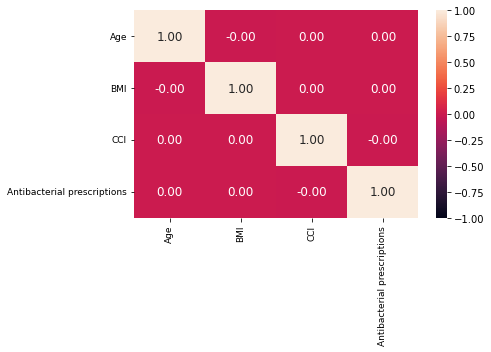

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti_combined[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti_combined/corr_urti_combined.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [35]:
data_urti_combined = data_urti_combined[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'urti_combined_ab_date', 'ab_type_cat', 'incdt_urti_combined_date', 'date', 'period',
                                   'event_urti_combined_admitted', 'duration_urti_combined_admitted'
                                    ]]

In [36]:
#switch variable urti_combined_ab_date into a binary variable
data_urti_combined[['ab_binary']] = data_urti_combined[['urti_combined_ab_date']].where(data_urti_combined[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_urti_combined_incdt = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 0]
data_urti_combined_prevl = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 1]

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_urti_combined_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_urti_combined_no_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_urti_combined_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 1]

In [37]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_urti_combined_incdt_prepandemic = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'prepandemic']
data_urti_combined_incdt_during_pandemic = data_urti_combined_incdt[(data_urti_combined_incdt['period'] == 'during_pandemic')]
data_urti_combined_incdt_post_2nd_lockdown = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'post_2nd_lockdown']
data_urti_combined_prevl_prepandemic = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'prepandemic']
data_urti_combined_prevl_during_pandemic = data_urti_combined_prevl[(data_urti_combined_prevl['period'] == 'during_pandemic')]
data_urti_combined_prevl_post_2nd_lockdown = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt_prepandemic = data_urti_combined_incdt_prepandemic[data_urti_combined_incdt_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_during_pandemic = data_urti_combined_incdt_during_pandemic[data_urti_combined_incdt_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_post_2nd_lockdown = data_urti_combined_incdt_post_2nd_lockdown[data_urti_combined_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_prepandemic = data_urti_combined_prevl_prepandemic[data_urti_combined_prevl_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_during_pandemic = data_urti_combined_prevl_during_pandemic[data_urti_combined_prevl_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_post_2nd_lockdown = data_urti_combined_prevl_post_2nd_lockdown[data_urti_combined_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_urti_combined
# save data
data_urti_combined.to_csv('../output/hospitalisation_prediction_urti_combined/data_urti_combined.csv')

Stored 'data_urti_combined' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [39]:
#make summary tables
make_summary_table('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt)
make_summary_table('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt)
make_summary_table('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl)
make_summary_table('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 219741 total observations, 218259 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 219741
number of events observed = 1482
   partial log-likelihood = -18202.76
         time fit was run = 2023-07-06 20:12:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.10       0.08            -0.07             0.25                 0.94                 1.29
CCI_cat[T.medium]                0.30       1.34       0.09             0.13             0.47                 1.14                 1.59
CCI_cat[T.high]                  0.20       1.22       0.10            -0.00             0.40                 1.00                 1.50
CCI_cat[T.very_high]             0.09       1.10       0.09            -0.09             0.28                 0.91                 1.32
age_cat[T.25_34]                 0.02       1.02       0.10            -0.17             0.21                 0.84                 1.24
age_cat[T.35_44]                 0.07       1.08       0.10            -0.12             0.26                 0.89                 1.30
age_cat[T.45_54]                -0.05       0.95       0.10            -0.24             0.14                 0.78                 1.15
age_cat[T.55_64]                 0.03       1.03       0.10            -0.16             0.22                 0.85                 1.25
age_cat[T.65_74]                -0.03       0.97       0.10            -0.23             0.16                 0.80                 1.17
age_cat[T.75_more]               0.02       1.02       0.10            -0.17             0.21                 0.85                 1.24
antibacterial_brit              -0.00       1.00       0.02            -0.04             0.03                 0.96                 1.03
bmi_cat[T.obese]                 0.03       1.04       0.10            -0.16             0.23                 0.85                 1.26
bmi_cat[T.overweight]            0.11       1.12       0.12            -0.12             0.35                 0.88                 1.42
bmi_cat[T.underweight]           0.31       1.37       0.16             0.00             0.62                 1.00                 1.87
bmi_cat[T.unknown]               0.09       1.09       0.11            -0.12             0.30                 0.89                 1.35
ethnicity[T.other]               0.17       1.19       0.13            -0.08             0.43                 0.92                 1.53
ethnicity[T.unknown]            -0.03       0.98       0.11            -0.24             0.19                 0.79                 1.21
ethnicity[T.white]               0.03       1.03       0.10            -0.17             0.23                 0.85                 1.26
flu_vaccine[T.yes]               0.09       1.10       0.08            -0.07             0.26                 0.93                 1.29
imd[T.medium]                    0.07       1.07       0.08            -0.10             0.23                 0.91                 1.26
imd[T.unaffluent]                0.00       1.00       0.08            -0.16             0.17                 0.85                 1.18
imd[T.unknown]                   0.19       1.21       0.12            -0.05             0.43                 0.96                 1.54
imd[T.very_affluent]            -0.04       0.96       0.09            -0.21             0.13                 0.81                 1.14
imd[T.very_unaffluent]           0.00       1.00       0.08            -0.17             0.17                 0.85                 1.18
region[T.east_midlands]         -0.13       0

13064


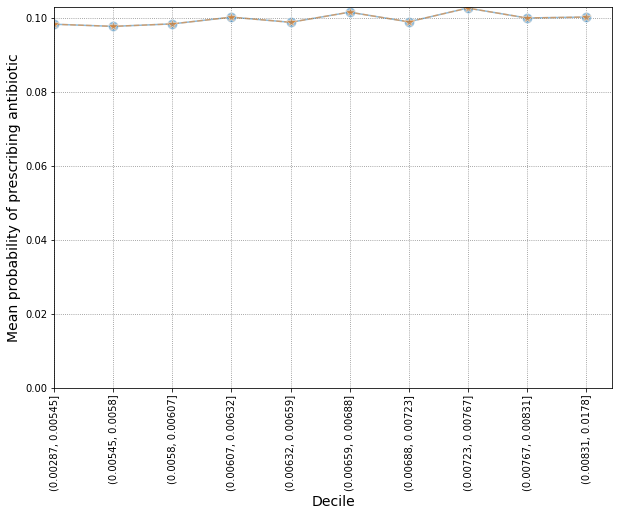


AUROC of LR for deciles with development and validation data: 0.50476 and 0.50307
AUROC of RF for deciles with development and validation data: 0.50474 and 0.50274
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00287, 0.00545]  0.107882  0.103404  0.112553
bins_(0.00545, 0.0058]   0.108346  0.103865  0.113021
bins_(0.0058, 0.00607]   0.108491  0.104005  0.113171
bins_(0.00607, 0.00632]  0.109752  0.105234  0.114463
bins_(0.00632, 0.00659]  0.109346  0.104849  0.114036
bins_(0.00659, 0.00688]  0.111781  0.107208  0.116549
bins_(0.00688, 0.00723]  0.109035  0.104525  0.113740
bins_(0.00723, 0.00767]  0.113648  0.109028  0.118463
bins_(0.00767, 0.00831]  0.109718  0.105220  0.114408
bins_(0.00831, 0.0178]   0.113226  0.108626  0.118019

RF feature importance:
                           rf_coef
bins_(0.00723, 0.00767]  0.186095
bins_(0.00831, 0.0178]   0.160963
bins_(0.00287, 0.00545]  0.117275
bins_(0.00659, 0.00688]  0.108504
bins_(0.0058, 0.00607]   0.0

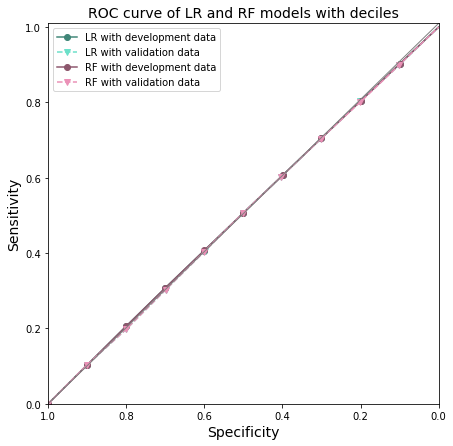

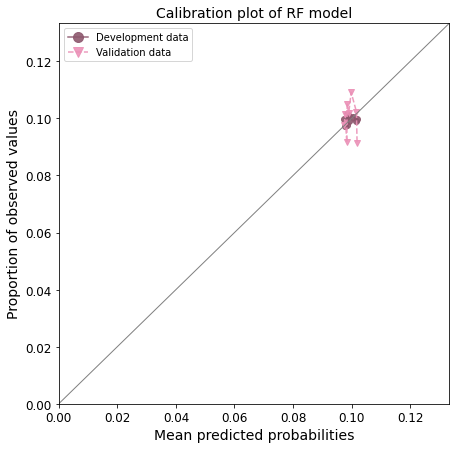

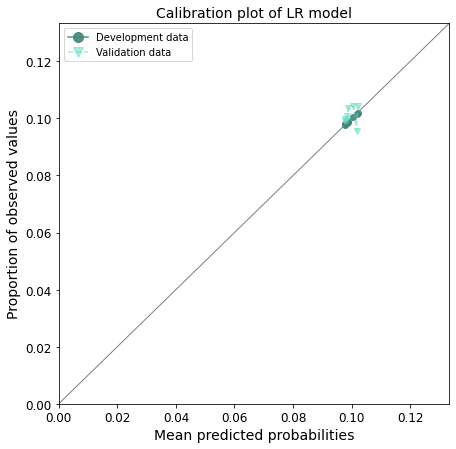


AUROC of LR for risk factors with development and validation data: 0.51116 and 0.50149
AUROC of RF for risk factors with development and validation data: 0.58497 and 0.50224
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.904906       NaN       NaN
age_cat_25_34                0.900643       NaN       NaN
age_cat_35_44                0.902756       NaN       NaN
age_cat_45_54                0.859977       NaN       NaN
age_cat_55_64                0.885509       NaN       NaN
age_cat_65_74                0.875405       NaN       NaN
age_cat_75_more              0.865940       NaN       NaN
sex_female                   0.651219   0.00000       inf
sex_male                     0.652192   0.00000       inf
CCI_cat_high                 0.845599   0.00000       inf
CCI_cat_low                  0.839407   0.00000       inf
CCI_cat_medium               0.849293   0.00000       inf
CCI_cat_very_high            0.826720   0.00000      

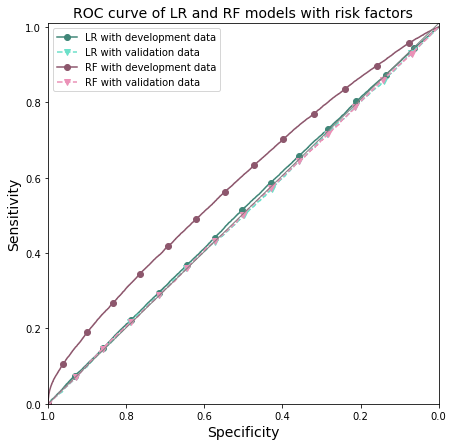

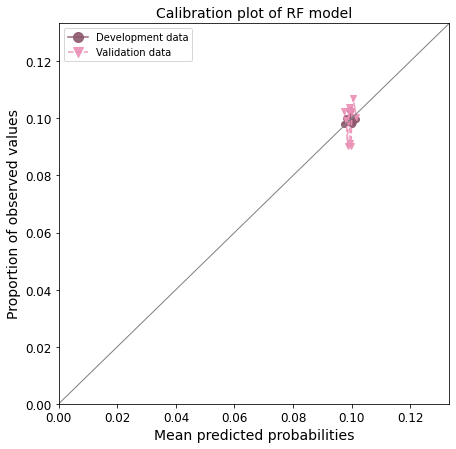

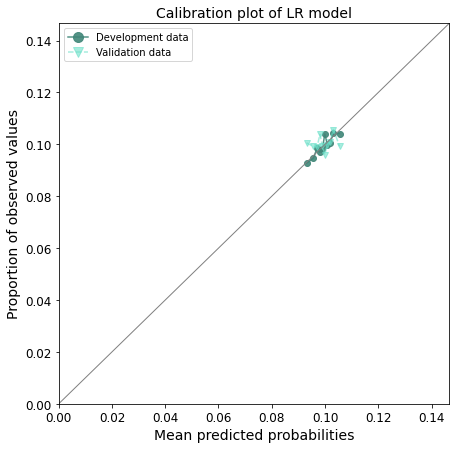

In [40]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt, prob_pred_urti_combined_no_abs_incdt_bin = cox_build('urti_combined', 'incdt', data_urti_combined_incdt, data_urti_combined_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('urti_combined', 'incdt_deciles', prob_pred_urti_combined_no_abs_incdt)

#make summary table of deciles
make_summary_table_deciles('urti_combined', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('urti_combined', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('urti_combined', 'incdt_riskfactors', prob_pred_urti_combined_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti_combined', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 24202 total observations, 24066 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 24202
number of events observed = 136
   partial log-likelihood = -1352.18
         time fit was run = 2023-07-06 20:13:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.33       0.30            -0.30             0.88                 0.74                 2.41
CCI_cat[T.medium]                0.67       1.95       0.31             0.07             1.27                 1.07                 3.57
CCI_cat[T.high]                  0.36       1.43       0.37            -0.37             1.09                 0.69                 2.97
CCI_cat[T.very_high]             0.69       1.99       0.32             0.06             1.31                 1.06                 3.71
age_cat[T.25_34]                 0.03       1.03       0.32            -0.60             0.66                 0.55                 1.93
age_cat[T.35_44]                 0.05       1.05       0.32            -0.57             0.67                 0.56                 1.95
age_cat[T.45_54]                 0.22       1.25       0.30            -0.37             0.82                 0.69                 2.27
age_cat[T.55_64]                 0.15       1.17       0.31            -0.45             0.76                 0.63                 2.14
age_cat[T.65_74]                -0.30       0.74       0.35            -0.98             0.37                 0.38                 1.45
age_cat[T.75_more]              -0.44       0.64       0.36            -1.15             0.26                 0.32                 1.30
antibacterial_brit               0.07       1.07       0.06            -0.04             0.19                 0.96                 1.21
bmi_cat[T.obese]                 0.27       1.31       0.37            -0.47             1.00                 0.63                 2.72
bmi_cat[T.overweight]            0.63       1.88       0.42            -0.18             1.45                 0.83                 4.25
bmi_cat[T.underweight]           0.84       2.31       0.52            -0.18             1.85                 0.83                 6.37
bmi_cat[T.unknown]               0.28       1.33       0.39            -0.49             1.06                 0.61                 2.88
ethnicity[T.other]               0.15       1.16       0.49            -0.81             1.10                 0.45                 3.00
ethnicity[T.unknown]             0.31       1.36       0.39            -0.46             1.07                 0.63                 2.92
ethnicity[T.white]               0.28       1.33       0.37            -0.44             1.01                 0.64                 2.74
flu_vaccine[T.yes]              -0.31       0.73       0.31            -0.93             0.31                 0.39                 1.36
imd[T.medium]                   -0.01       0.99       0.29            -0.57             0.55                 0.57                 1.74
imd[T.unaffluent]                0.29       1.34       0.27            -0.24             0.82                 0.79                 2.28
imd[T.unknown]                   0.26       1.29       0.41            -0.55             1.06                 0.58                 2.88
imd[T.very_affluent]            -0.03       0.97       0.29            -0.60             0.53                 0.55                 1.70
imd[T.very_unaffluent]          -0.08       0.93       0.29            -0.65             0.50                 0.52                 1.64
region[T.east_midlands]         -0.13       0.88  

13047


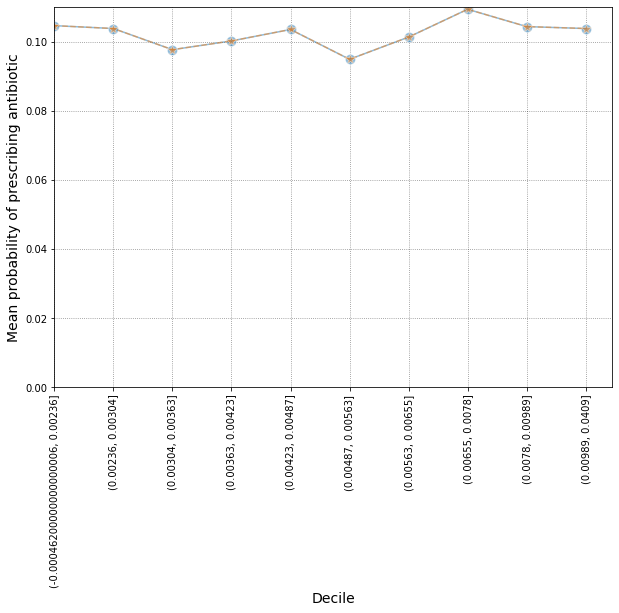


AUROC of LR for deciles with development and validation data: 0.51048 and 0.51137
AUROC of RF for deciles with development and validation data: 0.51048 and 0.51126
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.00046200000000000006, 0.00236]  0.115274  0.101861  0.130452
bins_(0.00236, 0.00304]                  0.114904  0.101446  0.130148
bins_(0.00304, 0.00363]                  0.109867  0.096779  0.124725
bins_(0.00363, 0.00423]                  0.113487  0.100203  0.128532
bins_(0.00423, 0.00487]                  0.114895  0.101529  0.130021
bins_(0.00487, 0.00563]                  0.104875  0.092204  0.119287
bins_(0.00563, 0.00655]                  0.109736  0.096687  0.124546
bins_(0.00655, 0.0078]                   0.121048  0.107183  0.136707
bins_(0.0078, 0.00989]                   0.118427  0.104766  0.133869
bins_(0.00989, 0.0409]                   0.114380  0.100987  0.129550

RF feature importance:
                       

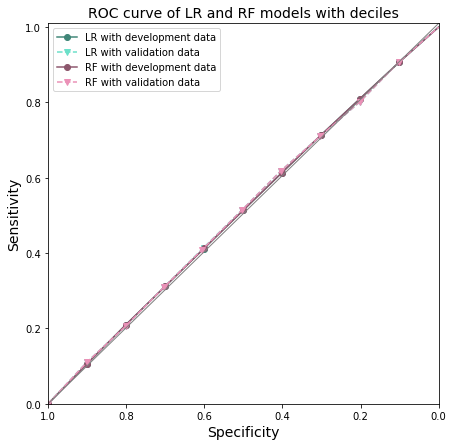

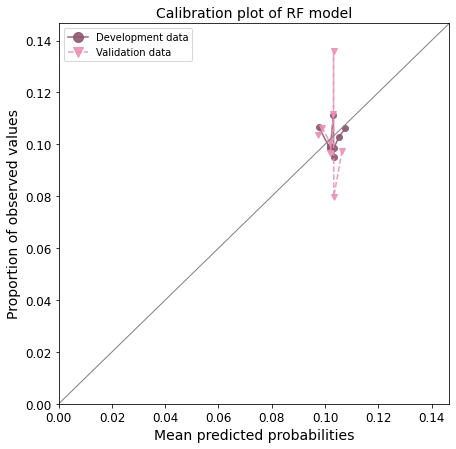

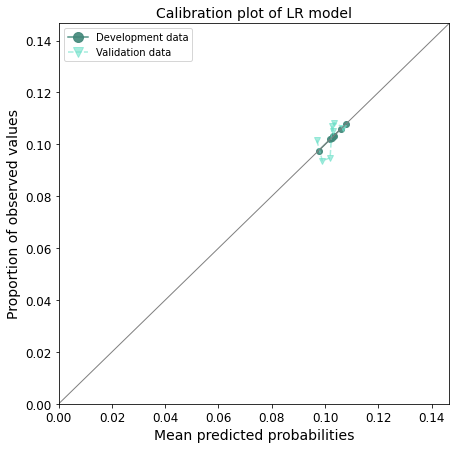


AUROC of LR for risk factors with development and validation data: 0.52946 and 0.51052
AUROC of RF for risk factors with development and validation data: 0.73861 and 0.50139
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.910903  0.000000       inf
age_cat_25_34                0.890810  0.000000       inf
age_cat_35_44                0.832131  0.000000       inf
age_cat_45_54                0.879074  0.000000       inf
age_cat_55_64                0.885014  0.000000       inf
age_cat_65_74                0.889466  0.000000       inf
age_cat_75_more              0.909046  0.000000       inf
sex_female                   0.647071  0.000000       inf
sex_male                     0.656428  0.000000       inf
CCI_cat_high                 0.800988       NaN       NaN
CCI_cat_low                  0.856343       NaN       NaN
CCI_cat_medium               0.879299       NaN       NaN
CCI_cat_very_high            0.856039       NaN      

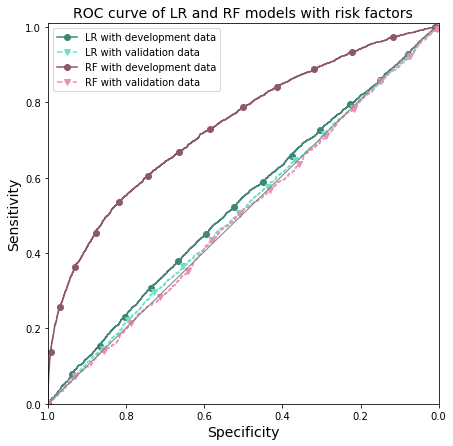

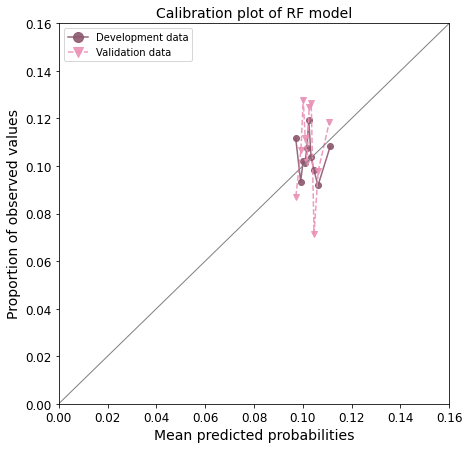

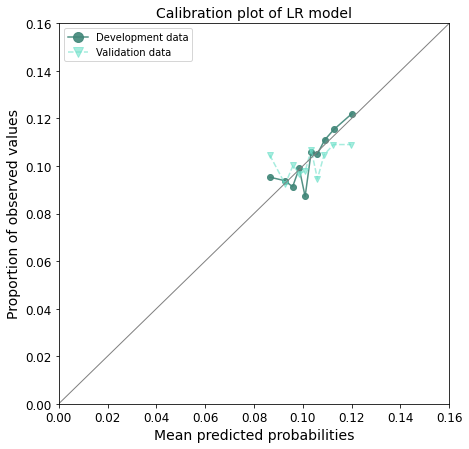

In [41]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl, prob_pred_urti_combined_no_abs_prevl_bin = cox_build('urti_combined', 'prevl', data_urti_combined_prevl, data_urti_combined_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('urti_combined', 'prevl_deciles', prob_pred_urti_combined_no_abs_prevl)

#make summary table of deciles
make_summary_table_deciles('urti_combined', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('urti_combined', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('urti_combined', 'prevl_riskfactors', prob_pred_urti_combined_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti_combined', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 57276 total observations, 56942 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 57276
number of events observed = 334
   partial log-likelihood = -3638.14
         time fit was run = 2023-07-06 20:13:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.32       0.18            -0.07             0.63                 0.94                 1.87
CCI_cat[T.medium]                0.44       1.56       0.19             0.08             0.81                 1.08                 2.24
CCI_cat[T.high]                  0.06       1.06       0.24            -0.41             0.53                 0.66                 1.70
CCI_cat[T.very_high]             0.18       1.19       0.21            -0.22             0.58                 0.80                 1.79
age_cat[T.25_34]                 0.05       1.05       0.19            -0.32             0.42                 0.72                 1.53
age_cat[T.35_44]                -0.04       0.96       0.19            -0.42             0.34                 0.66                 1.41
age_cat[T.45_54]                -0.36       0.70       0.21            -0.77             0.06                 0.46                 1.06
age_cat[T.55_64]                -0.29       0.75       0.21            -0.70             0.12                 0.50                 1.12
age_cat[T.65_74]                -0.21       0.81       0.20            -0.61             0.19                 0.54                 1.20
age_cat[T.75_more]              -0.12       0.89       0.20            -0.51             0.27                 0.60                 1.31
antibacterial_brit              -0.03       0.97       0.04            -0.10             0.05                 0.90                 1.05
bmi_cat[T.obese]                 0.20       1.22       0.22            -0.23             0.63                 0.79                 1.89
bmi_cat[T.overweight]            0.14       1.15       0.27            -0.38             0.66                 0.68                 1.94
bmi_cat[T.underweight]           0.38       1.46       0.34            -0.28             1.05                 0.75                 2.85
bmi_cat[T.unknown]               0.04       1.04       0.24            -0.43             0.51                 0.65                 1.66
ethnicity[T.other]               0.34       1.41       0.31            -0.26             0.95                 0.77                 2.57
ethnicity[T.unknown]             0.27       1.30       0.26            -0.25             0.78                 0.78                 2.18
ethnicity[T.white]               0.40       1.49       0.25            -0.08             0.88                 0.92                 2.42
flu_vaccine[T.yes]               0.04       1.04       0.18            -0.32             0.39                 0.73                 1.48
imd[T.medium]                    0.16       1.17       0.17            -0.18             0.50                 0.84                 1.65
imd[T.unaffluent]                0.24       1.27       0.17            -0.10             0.57                 0.91                 1.77
imd[T.unknown]                   0.06       1.07       0.27            -0.47             0.60                 0.62                 1.83
imd[T.very_affluent]            -0.18       0.84       0.19            -0.55             0.19                 0.58                 1.21
imd[T.very_unaffluent]          -0.10       0.90       0.18            -0.46             0.26                 0.63                 1.30
region[T.east_midlands]          0.19       1.21  

13051


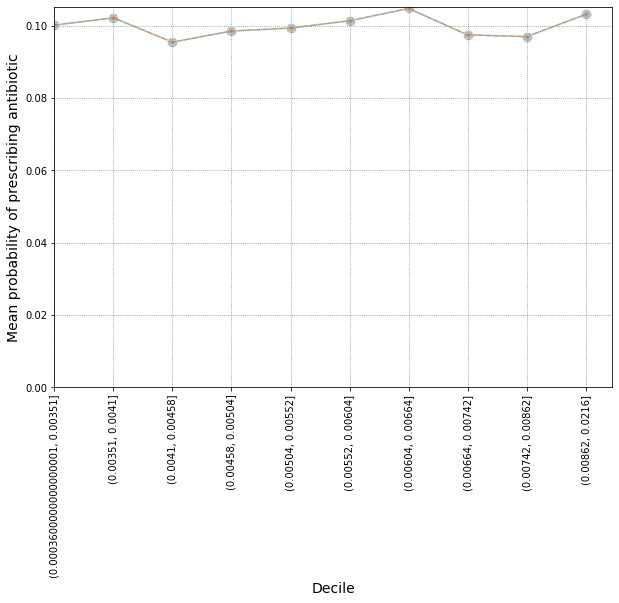


AUROC of LR for deciles with development and validation data: 0.50952 and 0.50489
AUROC of RF for deciles with development and validation data: 0.50949 and 0.50586
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0003600000000000001, 0.00351]  0.112052  0.103228  0.121630
bins_(0.00351, 0.0041]                 0.114475  0.105603  0.124091
bins_(0.0041, 0.00458]                 0.106660  0.098151  0.115907
bins_(0.00458, 0.00504]                0.108852  0.100200  0.118251
bins_(0.00504, 0.00552]                0.109529  0.100834  0.118973
bins_(0.00552, 0.00604]                0.111593  0.102860  0.121068
bins_(0.00604, 0.00664]                0.119788  0.110617  0.129720
bins_(0.00664, 0.00742]                0.106320  0.097833  0.115544
bins_(0.00742, 0.00862]                0.108315  0.099727  0.117641
bins_(0.00862, 0.0216]                 0.113181  0.104364  0.122744

RF feature importance:
                                         rf_c

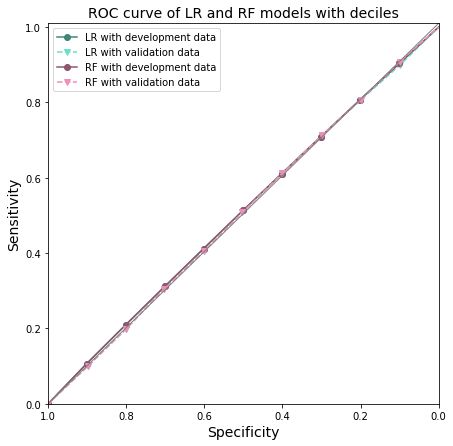

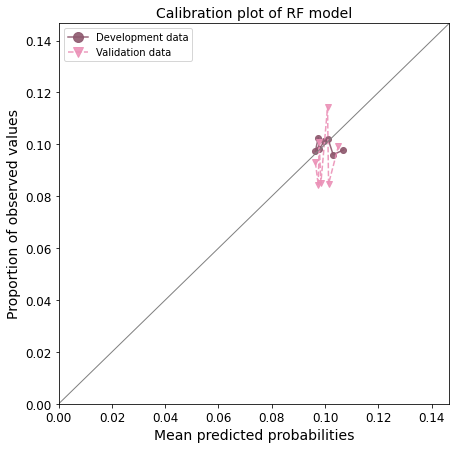

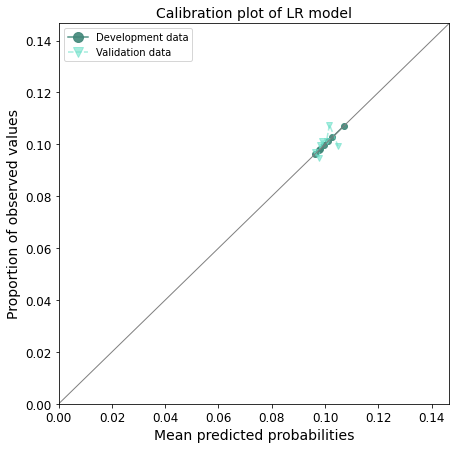

In [42]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_prepandemic, prob_pred_urti_combined_no_abs_incdt_prepandemic_bin = cox_build('urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic, data_urti_combined_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('urti_combined', 'incdt_prepandemic_deciles', prob_pred_urti_combined_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 66363 total observations, 65925 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 66363
number of events observed = 438
   partial log-likelihood = -4845.83
         time fit was run = 2023-07-06 20:13:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.15            -0.34             0.23                 0.71                 1.26
CCI_cat[T.medium]                0.20       1.22       0.15            -0.10             0.50                 0.90                 1.64
CCI_cat[T.high]                  0.10       1.10       0.19            -0.27             0.46                 0.76                 1.58
CCI_cat[T.very_high]             0.03       1.03       0.17            -0.30             0.35                 0.74                 1.43
age_cat[T.25_34]                 0.13       1.14       0.18            -0.22             0.49                 0.80                 1.63
age_cat[T.35_44]                 0.22       1.25       0.18            -0.13             0.57                 0.88                 1.77
age_cat[T.45_54]                 0.21       1.23       0.18            -0.14             0.56                 0.87                 1.75
age_cat[T.55_64]                 0.22       1.24       0.18            -0.13             0.57                 0.88                 1.76
age_cat[T.65_74]                -0.05       0.96       0.19            -0.42             0.33                 0.66                 1.39
age_cat[T.75_more]              -0.13       0.87       0.19            -0.51             0.25                 0.60                 1.28
antibacterial_brit               0.02       1.02       0.03            -0.05             0.08                 0.95                 1.09
bmi_cat[T.obese]                -0.04       0.96       0.18            -0.40             0.31                 0.67                 1.37
bmi_cat[T.overweight]            0.06       1.06       0.22            -0.37             0.48                 0.69                 1.62
bmi_cat[T.underweight]           0.18       1.20       0.30            -0.40             0.76                 0.67                 2.15
bmi_cat[T.unknown]              -0.08       0.92       0.19            -0.46             0.30                 0.63                 1.35
ethnicity[T.other]              -0.10       0.91       0.22            -0.53             0.33                 0.59                 1.40
ethnicity[T.unknown]            -0.40       0.67       0.18            -0.76            -0.04                 0.47                 0.96
ethnicity[T.white]              -0.31       0.74       0.16            -0.63             0.02                 0.53                 1.02
flu_vaccine[T.yes]               0.14       1.15       0.15            -0.16             0.43                 0.85                 1.54
imd[T.medium]                   -0.03       0.97       0.16            -0.33             0.28                 0.72                 1.32
imd[T.unaffluent]                0.01       1.01       0.15            -0.30             0.31                 0.74                 1.36
imd[T.unknown]                   0.16       1.17       0.23            -0.29             0.61                 0.75                 1.84
imd[T.very_affluent]             0.08       1.09       0.15            -0.22             0.38                 0.81                 1.46
imd[T.very_unaffluent]          -0.08       0.93       0.16            -0.39             0.23                 0.68                 1.26
region[T.east_midlands]         -0.22       0.80  

13063


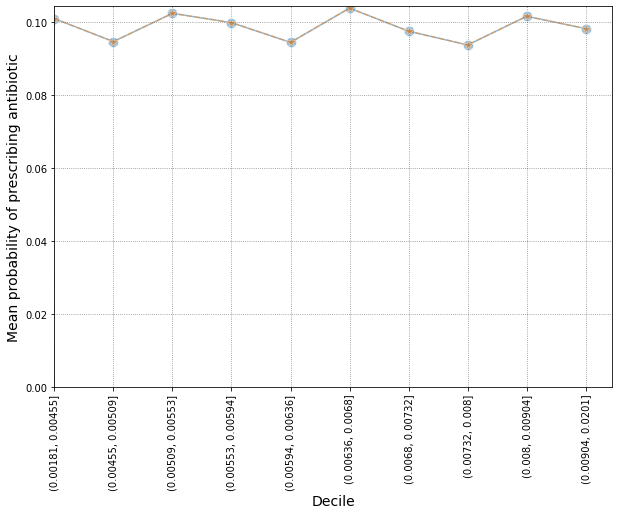


AUROC of LR for deciles with development and validation data: 0.51352 and 0.49551
AUROC of RF for deciles with development and validation data: 0.51351 and 0.49348
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00181, 0.00455]  0.113928  0.105666  0.122836
bins_(0.00455, 0.00509]  0.101505  0.093811  0.109830
bins_(0.00509, 0.00553]  0.115799  0.107437  0.124812
bins_(0.00553, 0.00594]  0.104984  0.097081  0.113531
bins_(0.00594, 0.00636]  0.103941  0.096152  0.112360
bins_(0.00636, 0.0068]   0.118219  0.109753  0.127338
bins_(0.0068, 0.00732]   0.106900  0.098929  0.115514
bins_(0.00732, 0.008]    0.107902  0.099922  0.116519
bins_(0.008, 0.00904]    0.112752  0.104543  0.121607
bins_(0.00904, 0.0201]   0.107993  0.099958  0.116674

RF feature importance:
                           rf_coef
bins_(0.00636, 0.0068]   0.211457
bins_(0.00455, 0.00509]  0.161650
bins_(0.00509, 0.00553]  0.143087
bins_(0.00594, 0.00636]  0.103784
bins_(0.00181, 0.00455]  0.0

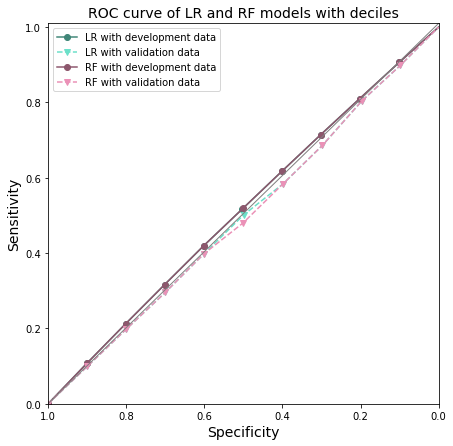

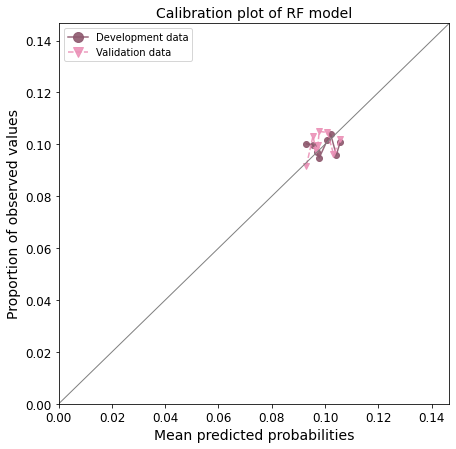

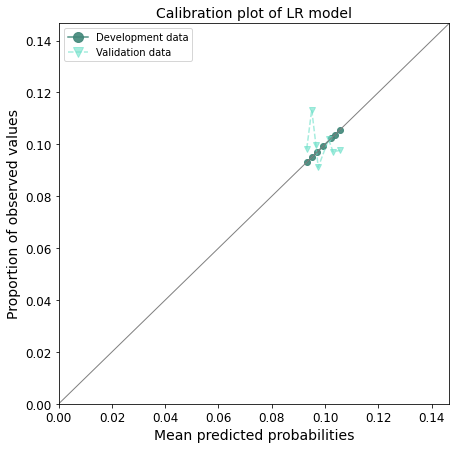

In [43]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_during_pandemic, prob_pred_urti_combined_no_abs_incdt_during_pandemic_bin = cox_build('urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic, data_urti_combined_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('urti_combined', 'incdt_during_pandemic_deciles', prob_pred_urti_combined_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 96101 total observations, 95439 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 96101
number of events observed = 662
   partial log-likelihood = -7572.59
         time fit was run = 2023-07-06 20:13:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.12            -0.19             0.27                 0.82                 1.31
CCI_cat[T.medium]                0.10       1.11       0.13            -0.15             0.35                 0.86                 1.42
CCI_cat[T.high]                  0.11       1.12       0.15            -0.18             0.41                 0.83                 1.51
CCI_cat[T.very_high]            -0.00       1.00       0.14            -0.27             0.27                 0.76                 1.31
age_cat[T.25_34]                -0.07       0.93       0.15            -0.37             0.23                 0.69                 1.26
age_cat[T.35_44]                 0.06       1.06       0.15            -0.23             0.35                 0.79                 1.42
age_cat[T.45_54]                 0.06       1.07       0.15            -0.23             0.36                 0.79                 1.43
age_cat[T.55_64]                 0.25       1.29       0.14            -0.03             0.53                 0.97                 1.70
age_cat[T.65_74]                 0.22       1.25       0.14            -0.06             0.50                 0.94                 1.66
age_cat[T.75_more]               0.06       1.06       0.15            -0.23             0.35                 0.79                 1.42
antibacterial_brit              -0.01       0.99       0.03            -0.06             0.05                 0.94                 1.05
bmi_cat[T.obese]                 0.21       1.23       0.16            -0.11             0.52                 0.90                 1.68
bmi_cat[T.overweight]            0.06       1.06       0.20            -0.32             0.45                 0.73                 1.56
bmi_cat[T.underweight]          -0.17       0.85       0.30            -0.75             0.42                 0.47                 1.52
bmi_cat[T.unknown]               0.30       1.36       0.17            -0.02             0.63                 0.98                 1.88
ethnicity[T.other]               0.19       1.21       0.21            -0.23             0.61                 0.80                 1.83
ethnicity[T.unknown]             0.21       1.23       0.18            -0.14             0.55                 0.87                 1.74
ethnicity[T.white]               0.23       1.26       0.17            -0.09             0.56                 0.91                 1.75
flu_vaccine[T.yes]              -0.05       0.95       0.13            -0.31             0.21                 0.73                 1.23
imd[T.medium]                    0.03       1.03       0.12            -0.20             0.26                 0.82                 1.30
imd[T.unaffluent]               -0.11       0.89       0.12            -0.35             0.13                 0.70                 1.13
imd[T.unknown]                  -0.36       0.70       0.21            -0.78             0.06                 0.46                 1.06
imd[T.very_affluent]            -0.25       0.78       0.13            -0.50             0.00                 0.61                 1.00
imd[T.very_unaffluent]          -0.21       0.81       0.13            -0.45             0.04                 0.63                 1.04
region[T.east_midlands]         -0.19       0.83  

13057


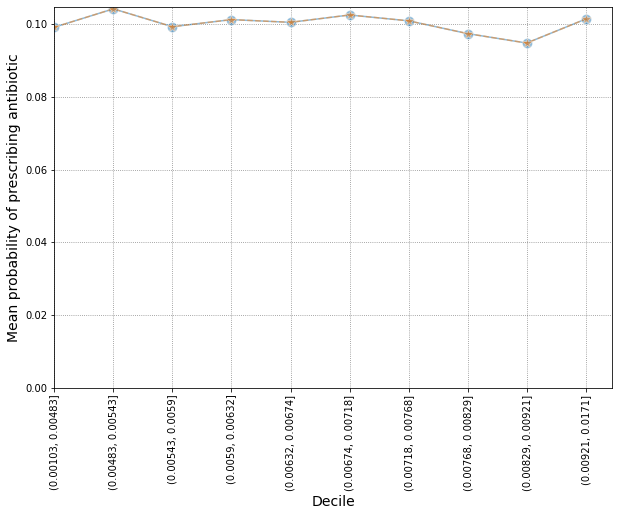


AUROC of LR for deciles with development and validation data: 0.50511 and 0.50997
AUROC of RF for deciles with development and validation data: 0.50511 and 0.50997
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00103, 0.00483]  0.111030  0.104213  0.118293
bins_(0.00483, 0.00543]  0.113919  0.107003  0.121281
bins_(0.00543, 0.0059]   0.112342  0.105478  0.119653
bins_(0.0059, 0.00632]   0.112173  0.105335  0.119455
bins_(0.00632, 0.00674]  0.108970  0.102233  0.116151
bins_(0.00674, 0.00718]  0.113440  0.106545  0.120780
bins_(0.00718, 0.00768]  0.111388  0.104579  0.118640
bins_(0.00768, 0.00829]  0.109633  0.102881  0.116828
bins_(0.00829, 0.00921]  0.106709  0.100091  0.113765
bins_(0.00921, 0.0171]   0.111296  0.104484  0.118553

RF feature importance:
                           rf_coef
bins_(0.00829, 0.00921]  0.184755
bins_(0.00483, 0.00543]  0.130080
bins_(0.00632, 0.00674]  0.110708
bins_(0.00674, 0.00718]  0.091851
bins_(0.00543, 0.0059]   0.0

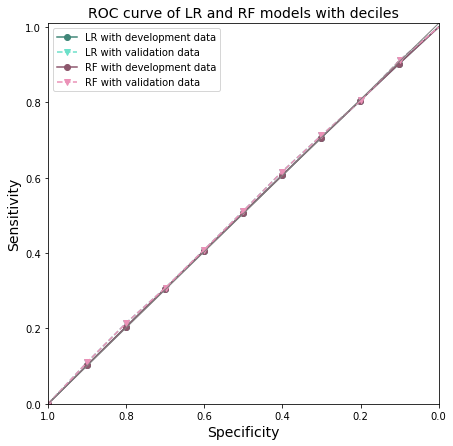

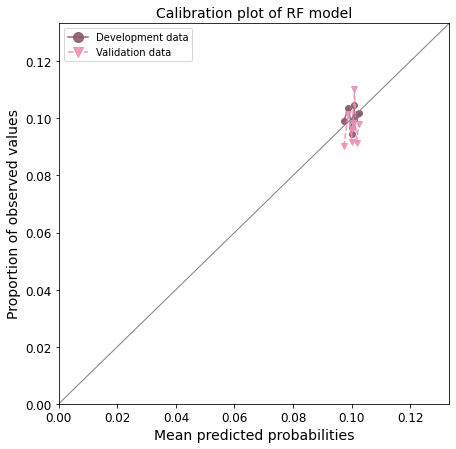

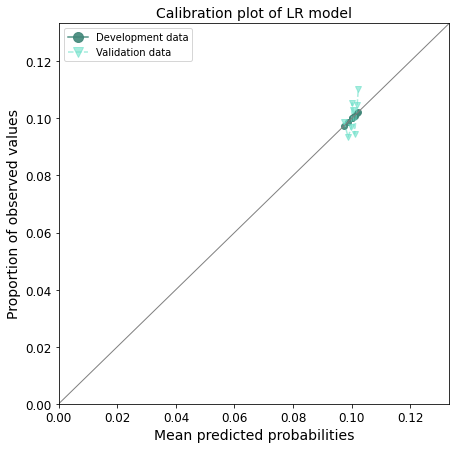

In [44]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown, prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown_bin = cox_build('urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown, data_urti_combined_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('urti_combined', 'incdt_post_2nd_lockdown_deciles', prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 6327 total observations, 6293 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 6327
number of events observed = 34
   partial log-likelihood = -271.97
         time fit was run = 2023-07-06 20:13:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.33       0.53            -0.76             1.32                 0.47                 3.76
CCI_cat[T.medium]                0.04       1.05       0.61            -1.15             1.24                 0.32                 3.45
CCI_cat[T.high]                  0.69       1.99       0.61            -0.51             1.88                 0.60                 6.56
CCI_cat[T.very_high]            -0.09       0.92       0.68            -1.42             1.24                 0.24                 3.46
age_cat[T.25_34]                -0.26       0.77       0.67            -1.58             1.06                 0.21                 2.88
age_cat[T.35_44]                -0.02       0.98       0.64            -1.27             1.22                 0.28                 3.40
age_cat[T.45_54]                 0.66       1.94       0.56            -0.44             1.77                 0.64                 5.87
age_cat[T.55_64]                -0.56       0.57       0.73            -1.99             0.88                 0.14                 2.40
age_cat[T.65_74]                 0.30       1.35       0.59            -0.86             1.46                 0.42                 4.29
age_cat[T.75_more]              -1.68       0.19       1.10            -3.83             0.48                 0.02                 1.61
antibacterial_brit               0.10       1.10       0.12            -0.13             0.33                 0.88                 1.38
bmi_cat[T.obese]                -0.55       0.58       0.56            -1.65             0.55                 0.19                 1.74
bmi_cat[T.overweight]           -0.19       0.83       0.68            -1.52             1.14                 0.22                 3.12
bmi_cat[T.underweight]           0.25       1.28       0.88            -1.47             1.96                 0.23                 7.12
bmi_cat[T.unknown]              -0.49       0.61       0.63            -1.73             0.74                 0.18                 2.10
ethnicity[T.other]               0.13       1.13       0.71            -1.28             1.53                 0.28                 4.60
ethnicity[T.unknown]            -0.28       0.76       0.61            -1.47             0.91                 0.23                 2.50
ethnicity[T.white]              -0.53       0.59       0.56            -1.63             0.57                 0.20                 1.77
flu_vaccine[T.yes]              -0.68       0.51       0.73            -2.11             0.76                 0.12                 2.13
imd[T.medium]                    0.39       1.47       0.50            -0.58             1.36                 0.56                 3.89
imd[T.unaffluent]                0.45       1.56       0.49            -0.51             1.40                 0.60                 4.05
imd[T.unknown]                  -0.54       0.58       1.08            -2.65             1.57                 0.07                 4.81
imd[T.very_affluent]            -1.28       0.28       0.81            -2.86             0.30                 0.06                 1.35
imd[T.very_unaffluent]          -0.82       0.44       0.69            -2.17             0.54                 0.11                 1.72
region[T.east_midlands]          1.80       6.05       

13064


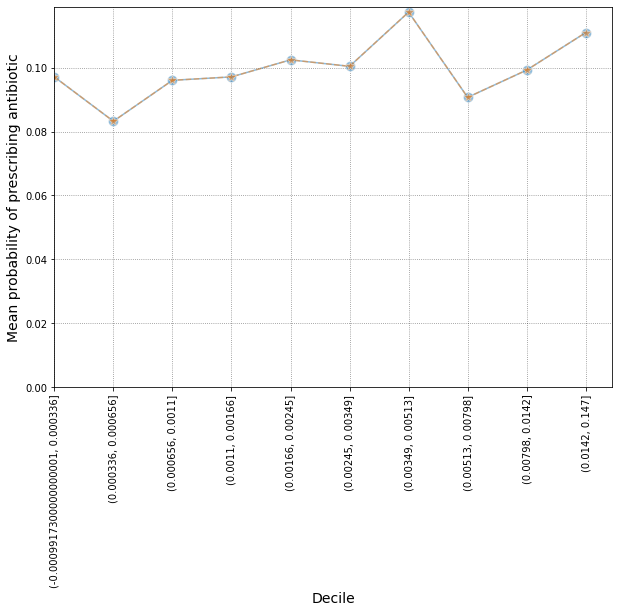


AUROC of LR for deciles with development and validation data: 0.54030 and 0.47447
AUROC of RF for deciles with development and validation data: 0.54029 and 0.47381
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.0009917300000000001, 0.000336]  0.116505  0.091274  0.148711
bins_(0.000336, 0.000656]                0.090620  0.069101  0.118841
bins_(0.000656, 0.0011]                  0.116427  0.091367  0.148361
bins_(0.0011, 0.00166]                   0.100763  0.078230  0.129787
bins_(0.00166, 0.00245]                  0.105678  0.082156  0.135936
bins_(0.00245, 0.00349]                  0.116904  0.091887  0.148731
bins_(0.00349, 0.00513]                  0.152000  0.122493  0.188616
bins_(0.00513, 0.00798]                  0.097372  0.075179  0.126118
bins_(0.00798, 0.0142]                   0.106750  0.083134  0.137076
bins_(0.0142, 0.147]                     0.132013  0.104559  0.166675

RF feature importance:
                       

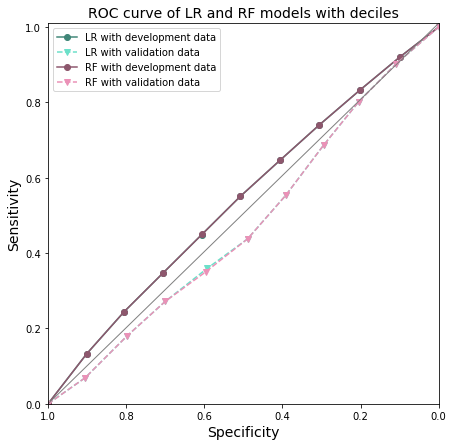

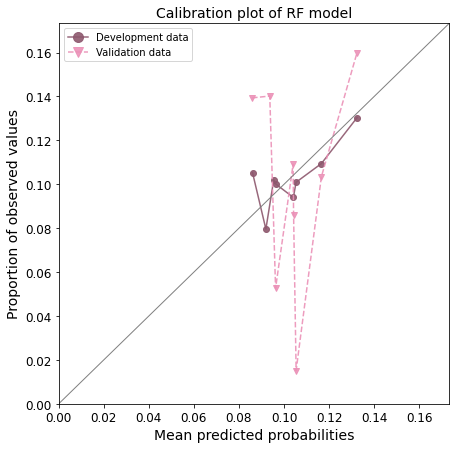

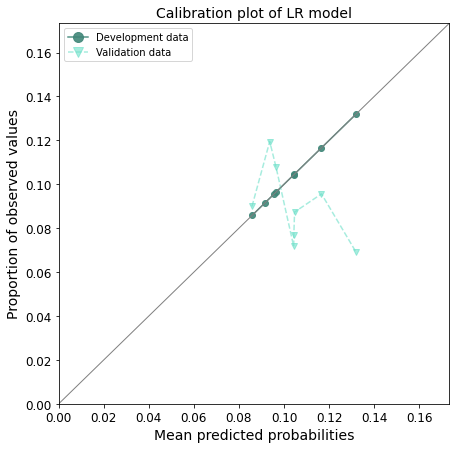

In [45]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_prepandemic, prob_pred_urti_combined_no_abs_prevl_prepandemic_bin = cox_build('urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic, data_urti_combined_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('urti_combined', 'prevl_prepandemic_deciles', prob_pred_urti_combined_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 7360 total observations, 7319 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7360
number of events observed = 41
   partial log-likelihood = -344.42
         time fit was run = 2023-07-06 20:13:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.50            -0.93             1.01                 0.39                 2.75
CCI_cat[T.medium]                0.10       1.11       0.54            -0.96             1.17                 0.38                 3.21
CCI_cat[T.high]                  0.54       1.71       0.58            -0.60             1.67                 0.55                 5.34
CCI_cat[T.very_high]             0.33       1.39       0.54            -0.73             1.39                 0.48                 4.03
age_cat[T.25_34]                 0.46       1.58       0.57            -0.66             1.58                 0.52                 4.87
age_cat[T.35_44]                -0.01       0.99       0.63            -1.25             1.23                 0.29                 3.44
age_cat[T.45_54]                 0.60       1.82       0.55            -0.48             1.68                 0.62                 5.34
age_cat[T.55_64]                 0.22       1.25       0.59            -0.93             1.37                 0.39                 3.95
age_cat[T.65_74]                -1.68       0.19       1.10            -3.83             0.47                 0.02                 1.60
age_cat[T.75_more]              -0.08       0.93       0.64            -1.32             1.17                 0.27                 3.22
antibacterial_brit               0.08       1.08       0.11            -0.13             0.29                 0.88                 1.33
bmi_cat[T.obese]                -0.41       0.67       0.57            -1.51             0.70                 0.22                 2.02
bmi_cat[T.overweight]            0.73       2.07       0.59            -0.43             1.88                 0.65                 6.54
bmi_cat[T.underweight]           0.82       2.27       0.77            -0.69             2.33                 0.50                10.29
bmi_cat[T.unknown]              -0.39       0.67       0.62            -1.60             0.81                 0.20                 2.26
ethnicity[T.other]              -0.25       0.78       0.92            -2.05             1.55                 0.13                 4.69
ethnicity[T.unknown]            -0.04       0.96       0.67            -1.36             1.27                 0.26                 3.56
ethnicity[T.white]               0.17       1.18       0.61            -1.03             1.37                 0.36                 3.92
flu_vaccine[T.yes]               0.02       1.02       0.53            -1.02             1.06                 0.36                 2.88
imd[T.medium]                   -0.22       0.80       0.45            -1.11             0.67                 0.33                 1.95
imd[T.unaffluent]               -0.09       0.91       0.45            -0.98             0.80                 0.37                 2.22
imd[T.unknown]                 -17.13       0.00    3333.35         -6550.38          6516.12                 0.00                  inf
imd[T.very_affluent]            -0.90       0.41       0.59            -2.05             0.25                 0.13                 1.28
imd[T.very_unaffluent]          -0.26       0.77       0.47            -1.18             0.65                 0.31                 1.92
region[T.east_midlands]         -0.83       0.44       

13079


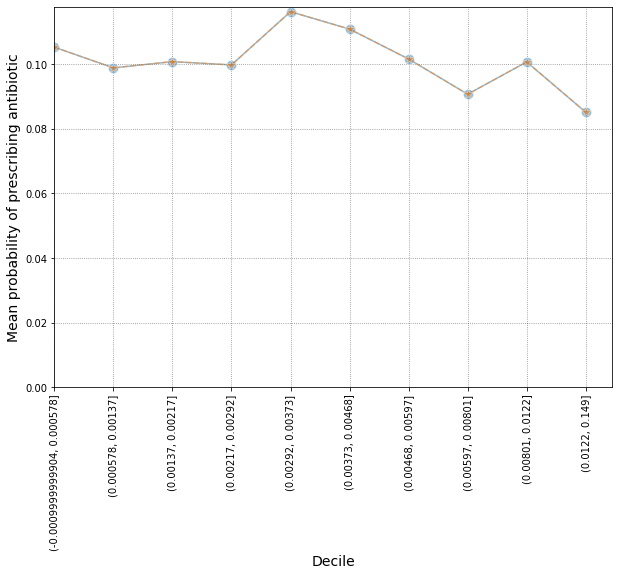


AUROC of LR for deciles with development and validation data: 0.53106 and 0.47898
AUROC of RF for deciles with development and validation data: 0.53105 and 0.48065
LR coefficients:
                                          OR  Lower CI  Upper CI
bins_(-0.0009999999904, 0.000578]  0.117241  0.093647  0.146781
bins_(0.000578, 0.00137]           0.122905  0.098496  0.153364
bins_(0.00137, 0.00217]            0.105479  0.083402  0.133401
bins_(0.00217, 0.00292]            0.118919  0.095339  0.148331
bins_(0.00292, 0.00373]            0.127223  0.102531  0.157862
bins_(0.00373, 0.00468]            0.118812  0.094760  0.148969
bins_(0.00468, 0.00597]            0.117333  0.094082  0.146331
bins_(0.00597, 0.00801]            0.088158  0.068673  0.113172
bins_(0.00801, 0.0122]             0.122253  0.098101  0.152350
bins_(0.0122, 0.149]               0.087969  0.068653  0.112719

RF feature importance:
                                     rf_coef
bins_(0.0122, 0.149]               0.215151


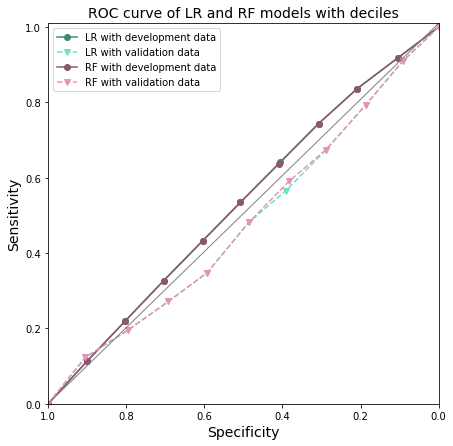

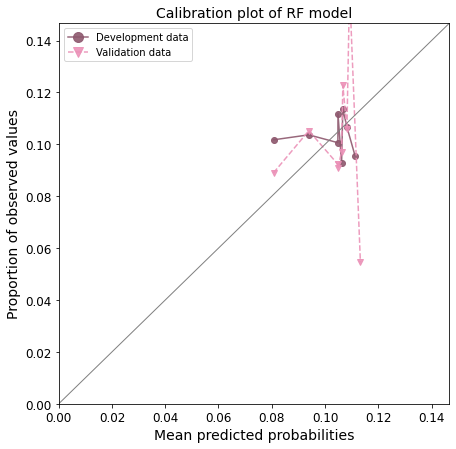

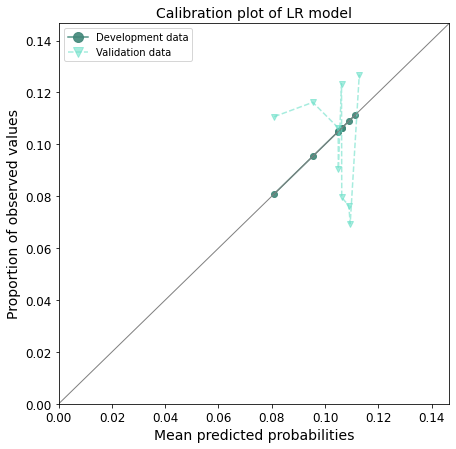

In [46]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_during_pandemic, prob_pred_urti_combined_no_abs_prevl_during_pandemic_bin = cox_build('urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic, data_urti_combined_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('urti_combined', 'prevl_during_pandemic_deciles', prob_pred_urti_combined_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 10514 total observations, 10439 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 10514
number of events observed = 75
   partial log-likelihood = -679.91
         time fit was run = 2023-07-06 20:14:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.57       1.77       0.42            -0.26             1.40                 0.77                 4.06
CCI_cat[T.medium]                0.86       2.37       0.43             0.01             1.72                 1.01                 5.56
CCI_cat[T.high]                  0.02       1.02       0.59            -1.13             1.17                 0.32                 3.22
CCI_cat[T.very_high]             0.70       2.00       0.46            -0.21             1.60                 0.81                 4.97
age_cat[T.25_34]                 0.03       1.03       0.41            -0.78             0.83                 0.46                 2.29
age_cat[T.35_44]                 0.07       1.07       0.40            -0.72             0.85                 0.49                 2.35
age_cat[T.45_54]                -0.08       0.92       0.42            -0.90             0.74                 0.41                 2.09
age_cat[T.55_64]                -0.08       0.92       0.42            -0.90             0.74                 0.41                 2.09
age_cat[T.65_74]                -0.39       0.67       0.46            -1.29             0.50                 0.28                 1.65
age_cat[T.75_more]              -0.40       0.67       0.46            -1.30             0.49                 0.27                 1.64
antibacterial_brit               0.04       1.04       0.08            -0.12             0.19                 0.89                 1.22
bmi_cat[T.obese]                 0.73       2.08       0.60            -0.44             1.91                 0.64                 6.74
bmi_cat[T.overweight]            1.08       2.95       0.65            -0.19             2.35                 0.83                10.46
bmi_cat[T.underweight]          -0.03       0.97       1.16            -2.30             2.23                 0.10                 9.33
bmi_cat[T.unknown]               0.73       2.08       0.62            -0.49             1.95                 0.61                 7.03
ethnicity[T.other]               0.82       2.27       0.54            -0.24             1.88                 0.79                 6.58
ethnicity[T.unknown]            -0.28       0.75       0.53            -1.32             0.75                 0.27                 2.12
ethnicity[T.white]               0.17       1.18       0.47            -0.76             1.09                 0.47                 2.98
flu_vaccine[T.yes]              -0.17       0.84       0.40            -0.96             0.61                 0.38                 1.83
imd[T.medium]                   -0.28       0.76       0.42            -1.10             0.55                 0.33                 1.73
imd[T.unaffluent]                0.35       1.42       0.37            -0.37             1.08                 0.69                 2.93
imd[T.unknown]                   0.54       1.71       0.50            -0.43             1.51                 0.65                 4.51
imd[T.very_affluent]            -0.05       0.95       0.39            -0.82             0.72                 0.44                 2.06
imd[T.very_unaffluent]           0.20       1.22       0.37            -0.53             0.93                 0.59                 2.54
region[T.east_midlands]         -0.17       0.85    

13056


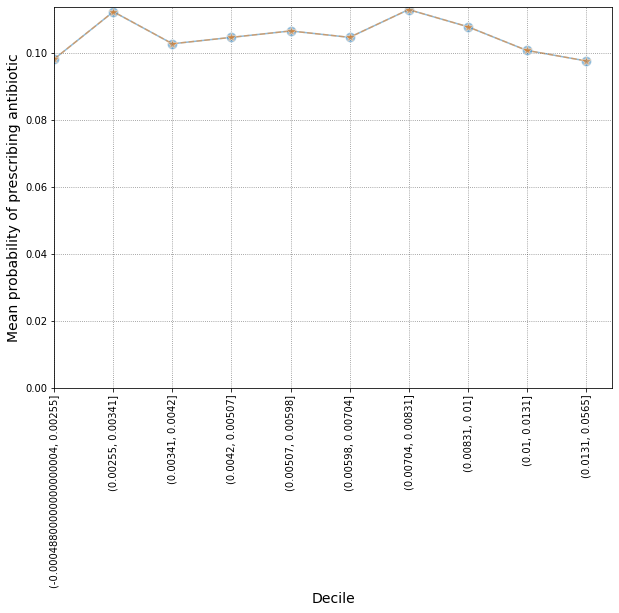


AUROC of LR for deciles with development and validation data: 0.51958 and 0.49299
AUROC of RF for deciles with development and validation data: 0.51957 and 0.49023
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.00048800000000000004, 0.00255]  0.110582  0.091284  0.133958
bins_(0.00255, 0.00341]                  0.128611  0.107721  0.153553
bins_(0.00341, 0.0042]                   0.112465  0.093124  0.135823
bins_(0.0042, 0.00507]                   0.110698  0.091602  0.133775
bins_(0.00507, 0.00598]                  0.120235  0.099723  0.144965
bins_(0.00598, 0.00704]                  0.124158  0.103398  0.149085
bins_(0.00704, 0.00831]                  0.124762  0.104042  0.149608
bins_(0.00831, 0.01]                     0.121832  0.101187  0.146690
bins_(0.01, 0.0131]                      0.121504  0.100992  0.146183
bins_(0.0131, 0.0565]                    0.099720  0.081750  0.121641

RF feature importance:
                       

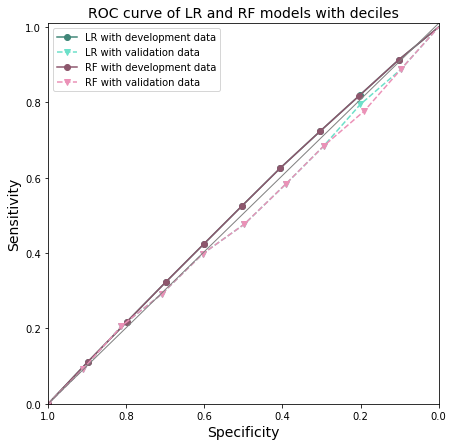

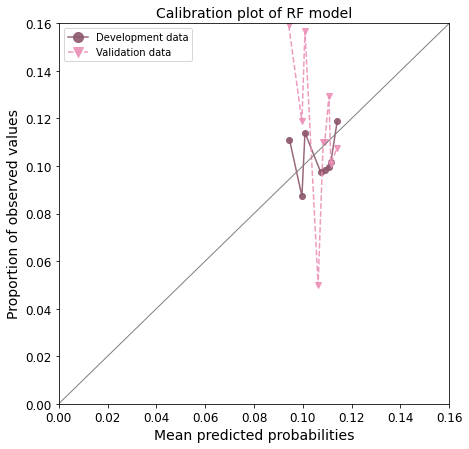

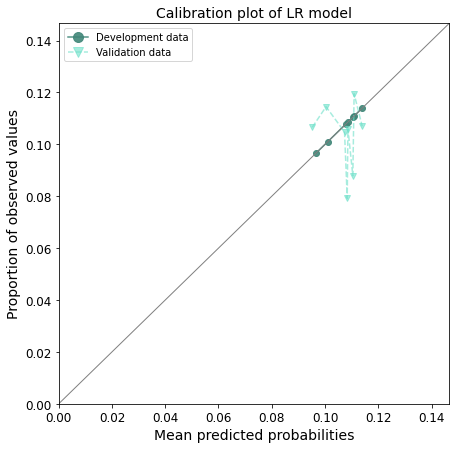

In [47]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown, prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown_bin = cox_build('urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown, data_urti_combined_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('urti_combined', 'prevl_post_2nd_lockdown_deciles', prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)